# Workshop de Python NFEFF

## Why are we locked down? The role of mobility in epidemic models

### Os objetivos desse workshop são:

1. Simular o modelo SEAIR avaliando o impacto da conectividade média $k$;
2. Estender o modelo SEAIR para dois concelhos com mobilidade entre eles;
3. Estender o modelo SEAIR para $N$ cidades/concelhos;
4. Aplicar o modelo SEAIR para Portugal avaliando a distribuição geográfica da doença no país;
---

* Primeiro importe as bibliotecas que vamos usar

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
#import networkx as nx


%matplotlib inline

Modelo SEAIR
============

No modelo **SEAIR**, para uma cidade com população $P$, temos os seguintes compartimentos:

1. $S$ = densidade de suscetíveis = número suscetíveis / $P$ 
2. $E$ = número de expostos = número expostos / $P$ 
3. $A$ = número de assintomáticos = número assintomáticos / $P$ 
4. $I$ = número de infectados = número infectados / $P$ 
5. $R$ = número de recuperados = número recuperados / $P$


---

Um suscetível passa para exposto quando em contato com um assintomático (probabilidade $\beta_A$) ou em contato com um infectado (probabilidade $\beta_I$). 

Supondo que um agente entre em **contato em média com $k$** pessoas por dia, então 

1. $S(t+1)=S(t)-\Pi S(t)$
2. $E(t+1)=E(t)+\Pi S(t)-\eta E(t)$
3. $A(t+1)=A(t)+\eta E(t)-\alpha A(t)$
4. $I(t+1)=I(t)+\alpha A(t)-\mu I(t)$
5. $R(t+1)=R(t)+\mu I(t)$

Onde $\Pi$ é a probabilidade de um agente ser infectado:

$$\Pi=1-(1-\beta_I)^{k I(t)}(1-\beta_A)^{k A(t)}$$
---
---

* Implementar uma função chamada **Epidemic_OneCity(k,\beta_I,\beta_A,\eta,\alpha,\mu)**, com a condição inicial:


1. $S(0)=1.0-0.01$
2. $E(0)=0.0$
3. $A(0)=0.01$
4. $I(0)=0.0$
5. $R(0)=0.0$


* Retornar a evolução temporal de $S(t)$, $E(t)+A(t)+I(t)$, e $R(t)$ e fazer um gráfico para elas.


* Se definirmos como **risco** $= E(t)+A(t)+I(t)$, então como muda a evolução do **risco** para diferentes valores de $k$?

Usar:
1. $\beta_I=0.06$
2. $\beta_A=0.06$
3. $\eta=1/2.32$
4. $\alpha=1/2.86$
5. $\mu=1/3.2$



In [17]:
def Epidemic_OneCity(k,beta_I,beta_A,eta,alpha,mu):
    
    S=1.0-0.0001
    E=0
    A=0.0001
    I=0.0
    R=0.0
    
    S_past = S
    E_past = E
    A_past = A
    I_past = I
    R_past = R
    
    T_max=100 #numero de dias maximo
    
    S_tempo = []
    risco = []
    R_tempo = []
    
    for t in range(T_max):
        PI = (1-((1-beta_A)**(k*A_past))*(1-beta_I)**(k*I_past))
        
        S = S_past - PI*S_past
        E = E_past + PI*S_past - eta*E_past
        A = A_past + eta*E_past - alpha*A_past     
        I = I_past + alpha*A_past - mu*I_past
        R = R_past + mu*I_past
        
        R_tempo.append(R)
        S_tempo.append(S)
        risco.append(E+I+A)

        S_past = S
        E_past = E
        A_past = A
        I_past = I
        R_past = R
            
    return S_tempo, risco, R_tempo

In [18]:
beta_I=0.06
beta_A=0.06
k=13.
eta=1/2.32
alpha=1/2.86
mu=1/3.2

S,risco,R=Epidemic_OneCity(k,beta_I,beta_A,eta,alpha,mu)


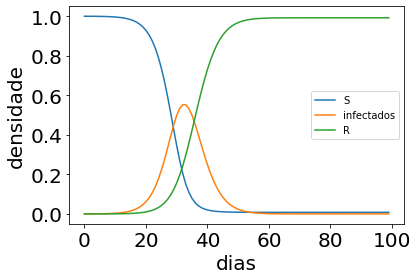

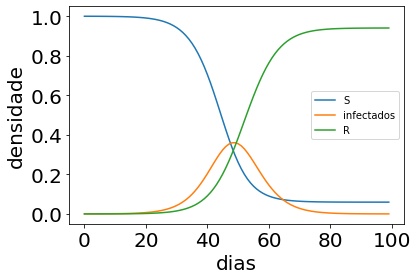

In [24]:
beta_I=0.06
beta_A=0.06
k=13.
eta=1/2.32
alpha=1/2.86
mu=1/3.2

S,risco,R=Epidemic_OneCity(k,beta_I,beta_A,eta,alpha,mu)

plt.xlabel("dias",size=20)
plt.ylabel("densidade",size=20)
plt.xticks(size=20)
plt.yticks(size=20)
  
plt.plot(np.arange(100),S,"-",label="S")
plt.plot(np.arange(100),risco,"-",label="infectados")
plt.plot(np.arange(100),R,"-",label="R")

plt.legend()
plt.show()


beta_I=0.06
beta_A=0.06
k=8.
eta=1/2.32
alpha=1/2.86
mu=1/3.2

S,risco,R=Epidemic_OneCity(k,beta_I,beta_A,eta,alpha,mu)

plt.xlabel("dias",size=20)
plt.ylabel("densidade",size=20)
plt.xticks(size=20)
plt.yticks(size=20)
  
plt.plot(np.arange(100),S,"-",label="S")
plt.plot(np.arange(100),risco,"-",label="infectados")
plt.plot(np.arange(100),R,"-",label="R")

plt.legend()



Modelo SEAIR com duas cidades
============

Para expandir o modelo **SEAIR** para duas cidades é necessário ter em conta a mobilidade entre elas, dado pela matriz OD:

$$ M= \begin{pmatrix} M_{00} & M_{01} \\ M_{10} & M_{11} \end{pmatrix}$$


$M_{ij}$ mede a fração da população que vai da cidade $i$ até a cidade $j$ todos os dias.

1. A mobilidade promove uma **MISTURA** entre os habitantes das duas cidades.

2. Todos os compartimentos e a população agora são vetores: S[0,1], E[0,1] .... N[0,1]

Cada cidade agora tem uma população efetiva:
$$P_{eff}[0]=M_{00}*P[0] + M_{01}*P[1];$$    
$$P_{eff}[1]=M_{10}*P[0] + M_{11}*P[1].$$

E o número de infectados e assintomáticos que em média uma pessoa da cidade $0$ pode encontrar é 
$$I_{eff}[0]=I[0]*M_{00}+I[1]*M_{10};$$
$$I_{eff}[1]=I[0]*M_{01}+I[1]*M_{11}.$$


Logo a probabilidade de infecção é:

$$p[0]=1-(1-\beta_I)^{k I_{eff}[0]P[0]/P_{eff}[0]}(1-\beta_A)^{k A_{eff}[0]P[0]/P_{eff}[0]};$$
$$p[1]=1-(1-\beta_I)^{k I_{eff}[1]P[1]/P_{eff}[1]}(1-\beta_A)^{k A_{eff}[1]P[1]/P_{eff}[1]},$$

---
e finalmente:

$$\Pi[0]=M_{00}*p[0]+M_{01}*p[1]$$
$$\Pi[1]=M_{10}*p[0]+M_{11}*p[1]$$

---

Através desse novo $\Pi_i$ podemos integrar todas as equações:

1. $S_i(t+1)=S_i(t)-\Pi_i S_i(t)$
2. $E_i(t+1)=E_i(t)+\Pi_i S_i(t)-\eta E_i(t)$
3. $A_i(t+1)=A_i(t)+\eta E_i(t)-\alpha A_i(t)$
4. $I_i(t+1)=I_i(t)+\alpha A_i(t)-\mu I_i(t)$
5. $R_i(t+1)=R_i(t)+\mu I_i(t)$

* Usando a matriz OD

$$ M= \begin{pmatrix} 0.9999 & 0.0001 \\ 0.0 & 1.0 \end{pmatrix},$$

população $P=[500000,50000]$, e $100$ **Assintomáticos** no tempo zero na primeira cidade. 

### Qual é a evolução da epidemia para as duas cidades? O que acontece se não tiver fluxo entre as cidades?


In [29]:
def Epidemic_TwoCities(k,beta_I,beta_A,eta,alpha,mu):
    
    #mobilidade
    M=np.array([[0.9999,0.0001],
               [0.0,1.0]])
    
    #M=np.array([[0.5,0.5],
    #           [0.0,1.0]])
    
    #populacao
    P=np.array([500000,50000])
    
    P_eff=np.dot(M.transpose(),P)
    
    A=np.array([100/P[0],0.0])
    S=np.array([1.0-A[0],1.0])
    E=np.array([0.0,0.0])
    I=np.array([0.0,0.0])
    R=np.array([0.0,0.0])
    
    S_past = S
    E_past = E
    A_past = A
    I_past = I
    R_past = R
    
    T_max=100 #numero de dias maximo
    
    
    risco_0 = []
    risco_1 = []
        
    for t in range(T_max):
                
        I_eff=np.dot(M.transpose(),P*I_past)/P_eff
        A_eff=np.dot(M.transpose(),P*A_past)/P_eff
        
        p=1-((1-beta_A)**(k*A_eff))*((1-beta_I)**(k*I_eff))
        
        PI=np.dot(M,p)

        S = S_past - PI*S_past
        E = E_past + PI*S_past - eta*E_past
        A = A_past + eta*E_past - alpha*A_past     
        I = I_past + alpha*A_past - mu*I_past
        R = R_past + mu*I_past
        
        
        risco_0.append(E[0]+I[0]+A[0])
        risco_1.append(E[1]+I[1]+A[1])
        
        S_past = S
        E_past = E
        A_past = A
        I_past = I
        R_past = R
        
    return(risco_0,risco_1)



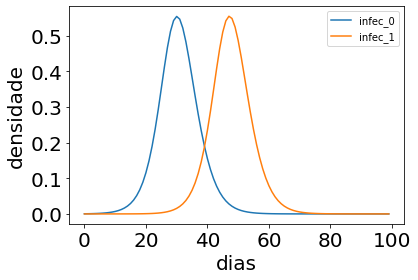

In [30]:
beta_I=0.06
beta_A=0.06
k=13.
eta=1/2.32
alpha=1/2.86
mu=1/3.2

risco_0,risco_1=Epidemic_TwoCities(k,beta_I,beta_A,eta,alpha,mu)

plt.xlabel("dias",size=20)
plt.ylabel("densidade",size=20)
plt.xticks(size=20)
plt.yticks(size=20)
  
plt.plot(np.arange(100),risco_0,"-",label="infec_0")
plt.plot(np.arange(100),risco_1,"-",label="infec_1")


plt.legend()

# Estender o código para N cidades

***Usar a notação de matrizes do numpy o máximo possível***
---

Uma vez estendido para N cidade, podemos simular para os 308 concelhos de Portugal. O dados demográficos estão no arquivo concelho_info.csv:


1. ID = Código de identificação do concelho;
2. Nome = Nome do concelho;
3. PopTot = População do concelho;
4. Superfície = Área do concelho;
5. NUT = Região do concelho;

*Só iremos usar as colunas ID, Nome, PopTot*

* Leia o concelho_info.csv usando
```Python
df_concelhos = pd.read_csv("concelho_info.csv",sep=",",dtype={"ID":str})```

* Guarde o vetor de IDs e Populações
```Python
Pop=np.array(df_concelhos.PopTot)
ID=np.array(df_concelhos.ID)```

* Ler arquivo *MatrizOD_artificial.txt* com a matriz OD de Portugal
```Python
def read_matrixOD(df_concelhos):
    infile=open("MatrizOD_artificial.txt","r")
    M=np.zeros((308,308))

    for line in infile:
        data=line.split(" ")
        flow=float(data[2])
        if flow>0.:
            A_index=df_concelhos.index[df_concelhos.ID==data[0][2:]].tolist()[0]
            B_index=df_concelhos.index[df_concelhos.ID==data[1][2:]].tolist()[0]
            M[A_index][B_index]=flow
        return M```
    
* Colocar 10 casos **Assintomáticos** em Lisboa como condição inicial

### Qual a evolução no número de casos em Portugal? Em Lisboa? No Porto?


In [33]:
def Epidemic_NCities(k,beta_I,beta_A,eta,alpha,mu,P,M):
    
    P_eff=np.dot(M.transpose(),P)
    
    
    A=np.zeros(len(P))
    cidade_foco=153 #Lisboa
    A[cidade_foco]=10/P[cidade_foco]  #escolher a cidade para começar a epidemia
    S=np.ones(len(P))-A
    E=np.zeros(len(P))
    I=np.zeros(len(P))
    R=np.zeros(len(P))
    
    
    S_past = S
    E_past = E
    A_past = A
    I_past = I
    R_past = R
    
    T_max=200 #numero de dias maximo
    
    risco_total = []
    risco_conselhos = []
        
    for t in range(T_max):
                
        I_eff=np.dot(M.transpose(),P*I_past)/P_eff
        A_eff=np.dot(M.transpose(),P*A_past)/P_eff
        
        p=1-((1-beta_A)**(k*A_eff))*((1-beta_I)**(k*I_eff))
        
        PI=np.dot(M,p)

        S = S_past - PI*S_past
        E = E_past + PI*S_past - eta*E_past
        A = A_past + eta*E_past - alpha*A_past     
        I = I_past + alpha*A_past - mu*I_past
        R = R_past + mu*I_past
                
        risco_total.append(np.sum((E+A+I)*P)/np.sum(P))
        risco_conselhos.append(E+A+I)
        
        S_past = S
        E_past = E
        A_past = A
        I_past = I
        R_past = R
        
    return(risco_total,risco_conselhos)



In [34]:
df_concelhos = pd.read_csv("concelho_info.csv",sep=",",dtype={"ID":str})
infile=open("MatrizOD_artificial.txt","r")

Pop=np.array(df_concelhos.PopTot)
ID=np.array(df_concelhos.ID)

M=np.zeros((308,308))

for line in infile:
    data=line.split(" ")
    flow=float(data[2])
    if flow>0.:
        A_index=df_concelhos.index[df_concelhos.ID==data[0][2:]].tolist()[0]
        B_index=df_concelhos.index[df_concelhos.ID==data[1][2:]].tolist()[0]
        M[A_index][B_index]=flow
M

array([[0.71723402, 0.05734671, 0.04294335, ..., 0.        , 0.        ,
        0.        ],
       [0.08706869, 0.56280232, 0.00326508, ..., 0.        , 0.        ,
        0.        ],
       [0.07903342, 0.00182613, 0.59289931, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.42857143, 0.42857143,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.42477876, 0.43362832,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

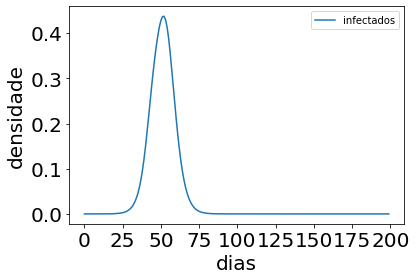

In [35]:
beta_I=0.06
beta_A=0.06
k=13.
eta=1/2.32
alpha=1/2.86
mu=1/3.2

risco_total,_=Epidemic_NCities(k,beta_I,beta_A,eta,alpha,mu,Pop,M)

plt.xlabel("dias",size=20)
plt.ylabel("densidade",size=20)
plt.xticks(size=20)
plt.yticks(size=20)
  
plt.plot(np.arange(200),risco_total,"-",label="infectados")

plt.legend()

# Visualização da evolução do número de casos em um mapa

Primeiro é necessário carregar o shapefile do mapa


```Python
fp = "concelhos-shapefile/concelhos.shp"
map_df = gpd.read_file(fp)
map_df.CCA_2=map_df.CCA_2.astype(int)```

Para fazer um **mapa coroplético** é necessário definir a variável a ser transformada nas cores. Vamos usar o *risco* definido como $A_i(t)+E_i(t)+I_i(t)$. 

* Construa um dicionário risco[i], onde i é o ID do concelho.
* Junte esse dicionário ao map_df usando o merge:
```Python
merged = map_df.merge(risco, how='left', left_on="CCA_2", right_on="ID")```

* Para plotar o mapa é necessário primeiro definir uma escala de cores e uma normalização
```Python
vmin, vmax = min(risco), max(risco)
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
"""Onde está Portugal Continental? e as ilhas?"""
plt.xlim(?,?)
plt.ylim(?,?)
cmap = plt.cm.get_cmap("inferno_r")
"""Porque a escala deve ser logarítmica?"""
norm = mpl.colors.SymLogNorm(0.0001, vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm)```

* Por fim 
```Python
merged.plot(column="risco", cmap=cmap, vmin=vmin,vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.1')
plt.savefig("mapa_dia%s.png"%dia,bbox_inches='tight',dpi=100)```

---

## Como evolui no tempo? Qual a diferença de começar em Lisboa ou Campo Maior?



In [36]:
fp = "concelhos-shapefile/concelhos.shp"
map_df = gpd.read_file(fp)
map_df.CCA_2=map_df.CCA_2.astype(int)

def print_mapa(risco,map_df):
    
    merged = map_df.merge(risco, how='left', left_on="CCA_2", right_on="ID")

    vmin, vmax = min(risco.risco), 0.01#max(risco.risco)
    fig, ax = plt.subplots(1, figsize=(30, 10))
    ax.axis('off')
    plt.xlim(-10,-5)
    plt.ylim(36,42.5)
    cmap = plt.cm.get_cmap("inferno_r")
    norm = mpl.colors.SymLogNorm(0.0001, vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm)
    merged.plot(column="risco", cmap=cmap, vmin=vmin,vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.1')
    plt.savefig('teste.jpg',bbox_inches="tight")
    

/home/hygor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  from ipykernel import kernelapp as app


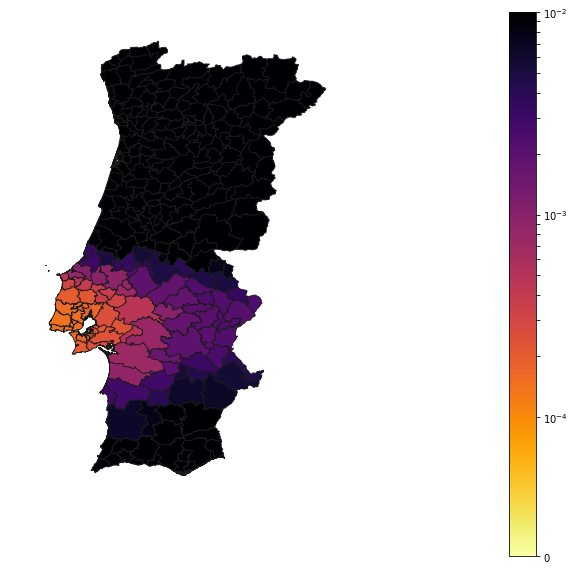

In [43]:
beta_I=0.06
beta_A=0.06
k=13.
eta=1/2.32
alpha=1/2.86
mu=1/3.2

risco_total,risco_conselhos=Epidemic_NCities(k,beta_I,beta_A,eta,alpha,mu,Pop,M)

data = {'ID':ID,'risco':risco_conselhos[70]}
risco=pd.DataFrame(data=data)
risco.ID=risco.ID.astype(int)
#risco.risco
print_mapa(risco,map_df)